In [40]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [26]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [27]:
df_train.shape, df_test.shape

((23856, 18), (15903, 17))

In [28]:
df_train.isnull().sum()

INCIDENT_ID           0
DATE                  0
X_1                   0
X_2                   0
X_3                   0
X_4                   0
X_5                   0
X_6                   0
X_7                   0
X_8                   0
X_9                   0
X_10                  0
X_11                  0
X_12                182
X_13                  0
X_14                  0
X_15                  0
MULTIPLE_OFFENSE      0
dtype: int64

In [29]:
df_test.isnull().sum()

INCIDENT_ID      0
DATE             0
X_1              0
X_2              0
X_3              0
X_4              0
X_5              0
X_6              0
X_7              0
X_8              0
X_9              0
X_10             0
X_11             0
X_12           127
X_13             0
X_14             0
X_15             0
dtype: int64

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 18 columns):
INCIDENT_ID         23856 non-null object
DATE                23856 non-null object
X_1                 23856 non-null int64
X_2                 23856 non-null int64
X_3                 23856 non-null int64
X_4                 23856 non-null int64
X_5                 23856 non-null int64
X_6                 23856 non-null int64
X_7                 23856 non-null int64
X_8                 23856 non-null int64
X_9                 23856 non-null int64
X_10                23856 non-null int64
X_11                23856 non-null int64
X_12                23674 non-null float64
X_13                23856 non-null int64
X_14                23856 non-null int64
X_15                23856 non-null int64
MULTIPLE_OFFENSE    23856 non-null int64
dtypes: float64(1), int64(15), object(2)
memory usage: 3.3+ MB


In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15903 entries, 0 to 15902
Data columns (total 17 columns):
INCIDENT_ID    15903 non-null object
DATE           15903 non-null object
X_1            15903 non-null int64
X_2            15903 non-null int64
X_3            15903 non-null int64
X_4            15903 non-null int64
X_5            15903 non-null int64
X_6            15903 non-null int64
X_7            15903 non-null int64
X_8            15903 non-null int64
X_9            15903 non-null int64
X_10           15903 non-null int64
X_11           15903 non-null int64
X_12           15776 non-null float64
X_13           15903 non-null int64
X_14           15903 non-null int64
X_15           15903 non-null int64
dtypes: float64(1), int64(14), object(2)
memory usage: 2.1+ MB


In [32]:
df_train.MULTIPLE_OFFENSE.value_counts(normalize=True)* 100

1    95.523139
0     4.476861
Name: MULTIPLE_OFFENSE, dtype: float64

In [33]:
df_train.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,MULTIPLE_OFFENSE
0,CR_102659,04-JUL-04,0,36,34,2,1,5,6,1,6,1,174,1.0,92,29,36,0
1,CR_189752,18-JUL-17,1,37,37,0,0,11,17,1,6,1,236,1.0,103,142,34,1
2,CR_184637,15-MAR-17,0,3,2,3,5,1,0,2,3,1,174,1.0,110,93,34,1
3,CR_139071,13-FEB-09,0,33,32,2,1,7,1,1,6,1,249,1.0,72,29,34,1
4,CR_109335,13-APR-05,0,33,32,2,1,8,3,0,5,1,174,0.0,112,29,43,1


In [34]:
df_test.head()

,INCIDENT_ID,DATE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
0,CR_195453,01-FEB-18,0,30,35,7,3,6,4,0,5,1,174,NaN,72,119,23
1,CR_103520,05-MAR-04,0,44,44,1,3,7,1,4,6,1,316,0.0,12,29,34
2,CR_196089,27-JAN-18,0,34,33,3,5,2,7,3,0,1,316,1.0,72,0,34
3,CR_112195,18-AUG-06,7,3,2,3,5,9,8,0,5,1,174,1.0,112,87,34
4,CR_149832,31-OCT-11,0,7,8,7,3,2,7,1,5,1,174,0.0,112,93,43


In [35]:
df_train1= df_train.copy()
df_train1.shape

(23856, 18)

## Getting info about data with pandas profiling 

In [14]:
import pandas_profiling
from pandas_profiling import ProfileReport
prof = ProfileReport(df_train1)

In [15]:
prof

In [36]:
# Fill NaN with mean
df_train["X_12"].fillna(df_train["X_12"].mean(), inplace=True)
df_test["X_12"].fillna(df_test["X_12"].mean(), inplace=True)

In [37]:
df_train.corr()['MULTIPLE_OFFENSE'].sort_values(ascending=False)

MULTIPLE_OFFENSE    1.000000
X_11                0.105088
X_15                0.044916
X_1                 0.014034
X_13                0.006512
X_9                -0.000748
X_4                -0.002921
X_5                -0.003450
X_6                -0.007903
X_7                -0.008036
X_14               -0.015267
X_3                -0.027218
X_2                -0.027293
X_8                -0.033397
X_12               -0.113041
X_10               -0.242596
Name: MULTIPLE_OFFENSE, dtype: float64

# Convert to X and Y

In [38]:
X_train, Y = df_train.drop(["INCIDENT_ID", "MULTIPLE_OFFENSE","DATE"], axis=1).values, df_train["MULTIPLE_OFFENSE"].values
X_test = df_test.drop(["INCIDENT_ID","DATE"], axis=1).values

X_train.shape, Y.shape, X_test.shape

((23856, 15), (23856,), (15903, 15))

## Perform Validation

In [41]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y[train], Y[test]
    
    model = CatBoostClassifier(random_state=27, max_depth=4, n_estimators=1000, verbose=500)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))

Learning rate set to 0.038597
0:	learn: 0.5990107	total: 9.61ms	remaining: 9.6s
500:	learn: 0.0056612	total: 9.79s	remaining: 9.75s
999:	learn: 0.0055623	total: 15s	remaining: 0us
0.9993692380933
Learning rate set to 0.038598
0:	learn: 0.6023222	total: 11.6ms	remaining: 11.6s
500:	learn: 0.0047571	total: 5.78s	remaining: 5.76s
999:	learn: 0.0047521	total: 10.8s	remaining: 0us
0.998733238810315
Learning rate set to 0.038598
0:	learn: 0.6022610	total: 10.9ms	remaining: 10.9s
500:	learn: 0.0062133	total: 4.95s	remaining: 4.93s
999:	learn: 0.0060255	total: 10.3s	remaining: 0us
0.9993688668261795
Learning rate set to 0.038598
0:	learn: 0.5997535	total: 12.2ms	remaining: 12.2s
500:	learn: 0.0057142	total: 5.84s	remaining: 5.82s
999:	learn: 0.0057078	total: 10.7s	remaining: 0us
0.9983232026828757
Learning rate set to 0.038598
0:	learn: 0.5995854	total: 11.6ms	remaining: 11.6s
500:	learn: 0.0055654	total: 6.1s	remaining: 6.07s
999:	learn: 0.0054796	total: 11.5s	remaining: 0us
0.999580800670719

## Make Final prediction using CatBoost

In [42]:
model = CatBoostClassifier(random_state=27,  n_estimators=1000, max_depth=4, verbose=500)
model.fit(X_train, Y)
preds1 = model.predict_proba(X_test)

Learning rate set to 0.041113
0:	learn: 0.5942157	total: 11ms	remaining: 11s
500:	learn: 0.0054035	total: 6.84s	remaining: 6.81s
999:	learn: 0.0053244	total: 12.6s	remaining: 0us


## Check Feature Importance

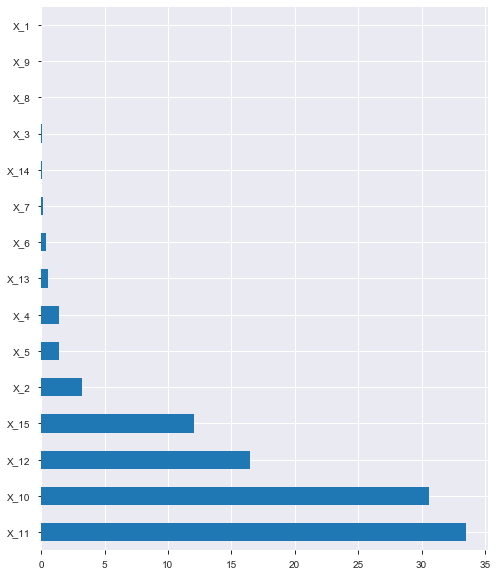

In [43]:
feat_imp = pd.Series(model.feature_importances_, index=df_train.drop(["INCIDENT_ID", "MULTIPLE_OFFENSE","DATE"], axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

## LightGBM

## Perform Validation

In [46]:
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train, test in kfold.split(X_train):
    x_train, x_test = X_train[train], X_train[test]
    y_train, y_test = Y[train], Y[test]
    
    num_class1, num_class2 = Counter(y_train)[1], Counter(y_train)[2], 
    sm = SMOTE(random_state=27)
    x_train, y_train = sm.fit_resample(x_train, y_train)
    
    model = LGBMClassifier(random_state=27, max_depth=6, n_estimators=400)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))

0.9991636164107136
0.999580800670719
0.999580800670719
0.9987476168244394
0.9997901835513042
Average:  0.999372603625579


## Make final Prediction using LightGBM

In [47]:
# We apply SMOTE on all classes, thus increasing total sample size of each class
# This generalizes the decision boundary
num_class1, num_class2 = Counter(Y)[1], Counter(Y)[2]
sm = SMOTE(random_state=27)
X_train, Y = sm.fit_resample(X_train, Y)

model = LGBMClassifier(random_state=27, max_depth=6, n_estimators=400)
model.fit(X_train, Y)
preds2 = model.predict_proba(X_test)

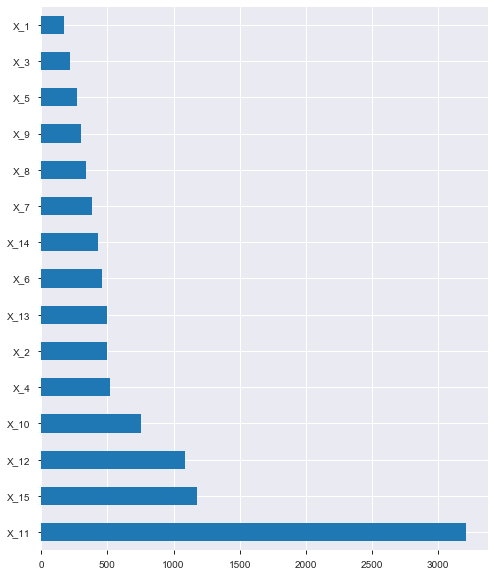

In [48]:
feat_imp = pd.Series(model.feature_importances_, index=df_train.drop(["INCIDENT_ID", "MULTIPLE_OFFENSE","DATE"], axis=1).columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [68]:
preds = list()
cb_weight=0.6 # Catboost
lb_weight=0.4 # LGBM
for i, j in zip(preds1, preds2):
    xx = [(cb_weight * i[0]) + (lb_weight * j[0]),
          (cb_weight * i[1]) + (lb_weight * j[1])]
    preds.append(xx)
print(preds[:10])
preds=np.argmax(preds,axis=1)

[[0.0003545896690353434, 0.9996454103309647], [1.6252311996223232e-05, 0.9999837476880038], [5.519883557423277e-05, 0.9999448011644257], [0.0003883538559093846, 0.9996116461440907], [2.474865944093185e-05, 0.9999752513405591], [1.0449489569896996e-05, 0.99998955051043], [6.115482648363368e-05, 0.9999388451735164], [6.843604231339117e-05, 0.9999315639576867], [6.589725219843245e-05, 0.9999341027478015], [0.004334554216619057, 0.9956654457833809]]


## Make Final Submisssion

In [69]:
incident_ids = df_test['INCIDENT_ID']

In [70]:
df_submit = pd.DataFrame({'INCIDENT_ID': incident_ids, 'MULTIPLE_OFFENSE': preds}) # Ensemble submission
df_submit.to_csv("submit2.csv", index=False)

In [71]:
df_submit.head()

,INCIDENT_ID,MULTIPLE_OFFENSE
0,CR_195453,1
1,CR_103520,1
2,CR_196089,1
3,CR_112195,1
4,CR_149832,1


In [72]:
df_submit.MULTIPLE_OFFENSE.value_counts()

1    15181
0      722
Name: MULTIPLE_OFFENSE, dtype: int64